## Assignment 7

# Tracking in conditions of correlated biased state and measurement noise

**Starodumova P., Antonov A., Babaev N., Krivova V. | Skoltech EDP course by Tatiana Podladchikova, 2020**

**The objectives of Assignment 7 is first to analyze the sensitivity of estimation results obtained by a Kalman filter that does not take into account correlation of state and measurement noise. Second is to develop optimal Kalman filter that takes into account correlated random acceleration to track a moving object. This problem is typical for many practical control  and forecasting problems. This will bring about a deeper understanding of main difficulties of practical Kalman filter implementation and skills to overcome these difficulties to get optimal assimilation output. Additional important outcome of this exercise is experience in developing algorithms to improve Kalman filter estimates.**

In [1]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt
import copy
np.random.seed(7)

### Part I. Sensitivity of estimation results obtained by a Kalman filter that doesn’t take into account the correlation of state noise (acceleration) and measurement noise.

**Firstly, we generate a true trajectory $x_i$ of an object motion disturbed by a correlated in time random acceleration. This random acceleration is presented by first-order Gauss-Markov process:**

In [2]:
def motion(initialX,initialV,initialT,lambdaVal,internalNoiseSigma,size):
    vectors = [initialX]
    acceleration = 0
    v = initialV
    for i in range(1,size):
        acceleration = np.exp(-lambdaVal*initialT)*acceleration + internalNoiseSigma*((1 - np.exp(-2*lambdaVal*initialT))**0.5)*np.random.normal(0, 1)
        vectors.append(vectors[i - 1] + v*initialT + acceleration*initialT**2/2)
        v = v + acceleration * initialT
    return vectors

In [3]:
# Initial conditions

lambda_1 = 1000
size = 200
initialX_1 = 5
initialV_1 = 1
internalNoiseSigma_1 = 0.2
T = 1

**Then, we generate measurements $z_i$ of the coordinate $x_i$:**

In [5]:
def measurements(process,lambdaVal,T,measSigma):
    meas = process.copy()
    noise = 0
    for i in range(0,len(meas)):
        noise = noise*np.exp(-lambdaVal*T) + np.random.normal(0,1)*measSigma*(1 - np.exp(-2*lambdaVal*T))**0.5
        meas[i] = meas[i] + noise
    return meas

In [6]:
# Standard deviation of measurement noise 

externalNoiseSigma = 20

**Some useful functions for Kalman filter algorithm development:**

In [10]:
# Function which takes two processes as input and returns their combination as a vector

def giveVectors(processX,processV):
    X = []
    lastIndexX = len(processX) - 1
    lastIndexV = len(processV) - 1
    for i in range(0,max(lastIndexX + 1,lastIndexV + 1)):
        x = [[],[]]
        if(lastIndexX < i):
            x[0].append(0)
        else:
            x[0].append(processX[i])
        if(lastIndexV < i):
            x[1].append(0)
        else:
            x[1].append(processV[i])
        X.append(np.matrix((x)))
    return X

In [11]:
# Function which takes a vector as input and returns dafa from a specified axis

def giveElements(vectors,index):
    x = []
    for i in range(0,len(vectors)):
        x.append((vectors[i][index].item(0)))
    return x

In [8]:
# Function for plotting

def showPlease(arr,legend,xlabel,ylabel,title):
    params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
    plt.rcParams.update(params)
    fig, ax = plt.subplots()
    max_len = 0
    for i in arr:
        if(len(i) > max_len):
            max_len = len(i)
    for i in arr:
        if(len(i) == max_len):
            plt.plot(i)
        else:
            plt.plot([j for j in range(max_len - len(i),max_len)],i)
    fig.set_figwidth(15)
    fig.set_figheight(7)
    plt.grid()
    plt.xlabel(xlabel, fontsize = 16)
    plt.ylabel(ylabel, fontsize = 16)
    plt.legend(legend)
    plt.title(title, fontsize = 16);
    plt.show()

**We develop Kalman filter algorithm to estimate state vector $X_i$ (extrapolation and filtration) with given initial filtered estimate and initial filtration error covariance matrix. The algorithm is as follows:**

In [13]:
class KalmanFilter:
    def __init__(self,initialX,initialP,measStates,trueTrajectory,typeofProcess,noiseSigma,vectorK,H,
                F,measSigma,G,lambdaProcess):
        self.trueTrajectory = trueTrajectory.copy()
        self.measTrajectory = giveElements(measStates,0)
        self.kalmanStates = []
        self.listP = []
        self.listK = []
        self.noiseSigma = noiseSigma
        self.measSigma = measSigma
        self.R = self.giveR()
        self.F = F
        self.H = H
        self.G = G
        self.lambdaProcess= lambdaProcess
        prevX = initialX.copy()
        prevP = initialP.copy()
        if(len(vectorK)):
            K = vectorK
            for i in range(0,len(measStates)):
                predictedX,predictedP = self.predict(prevX,prevP,self.giveF(i,i - 1),self.giveQ(i,typeofProcess,noiseSigma))
                prevX,prevP = self.filtrate(predictedX,predictedP,K,measStates[i][0],self.giveH(i),self.R)
                self.listP.append(prevP)
                self.kalmanStates.append(prevX)
                self.listK.append(K)
        else:
            for i in range(0,len(measStates)):
                predictedX,predictedP = self.predict(prevX,prevP,self.giveF(i,i - 1),self.giveQ(i,typeofProcess,noiseSigma))
                K = self.giveK(predictedP,self.giveH(i),self.R)
                prevX,prevP = self.filtrate(predictedX,predictedP,K,measStates[i][0],self.giveH(i),self.R)
                self.listP.append(prevP)
                self.kalmanStates.append(prevX)
                self.listK.append(K)
        self.kalmanTrajectory = giveElements(self.kalmanStates,0)
        
    def giveK(self):
        return self.listK.copy()
    
    def extrapolate(self,step):
        predictions = []
        for i in range(step-1,len(self.trueTrajectory)):
            predictions.append((self.giveF(i,i - 1)**(step - 1))*self.kalmanStates[i - step + 1])
        return predictions
    
    def errors(self,listValues):
        start = 0
        errors = []
        if(len(listValues) < len(self.trueTrajectory)):
            start = len(self.trueTrajectory) - len(listValues)
        for i in range(start,len(self.trueTrajectory)):
            errors.append((self.trueTrajectory[i] - listValues[i - start ])**2)
        return errors
    
    def giveQ(self,index,typeOfProcess,noiseSigma):#
        G = self.G
        if(typeOfProcess == "det"):
            return 0
        else:
            return G*G.T*(noiseSigma**2)*(1 - np.exp(-2*self.lambdaProcess))
        
    def giveK(self,predictedP,H,R):#
        return predictedP*H.T*(H*predictedP*H.T + R)**(-1)
    
    def giveR(self):#
        return self.measSigma**2
    
    def giveH(self,index):#
        return self.H
    
    def giveF(self,firstIndex,secondIndex):#
        return self.F
    
    def predict(self,prevX,prevP,F,Q):
        x = F*prevX
        P = F*prevP*F.T + Q
        return x,P
    
    def filtrate(self,predictedX,predictedP,K,meas,H,R):
        x = predictedX + K*(meas - H*predictedX)
        KH = K*H
        P = (np.identity(KH.shape[0]) - KH) * predictedP
        return x,P
    
    def givePError(self):
        p = []
        dimension = len(self.listP[0])
        for i in self.listP:
            x = [[] for j in range(0,dimension)]
            for j in range(0,dimension):
                x[j].append((i.item(j,j))**0.5)
            p.append(np.matrix(x))
        return p
    
    def errorsV(self,listValues):
        start = 0
        errors = []
        v = giveElements(self.kalmanStates,1)
        if(len(listValues) < len(self.trueTrajectory)):
            start = len(self.trueTrajectory) - len(listValues)
        for i in range(start,len(self.trueTrajectory)):
            errors.append((v[i] - listValues[i - start])**2)
        return errors
    
    def errorsA(self,listValues):
        start = 0
        errors = []
        a = giveElements(self.kalmanStates,2)
        if(len(listValues) < len(self.trueTrajectory)):
            start = len(self.trueTrajectory) - len(listValues)
        for i in range(start,len(self.trueTrajectory)):
            errors.append((a[i] - listValues[i - start])**2)
        return errors

**In order to present the system at state space, we introduce F - transition matrix that relates $X_i$ and $X_{i-1}$, G - input matrix that determines how random acceleration $a_i$ affects state vector, H - observation matrix:**

In [14]:
F = np.matrix([[1,T],
             [0,1]])
G = np.matrix([[T**2/2],
                 [T]])
H = np.matrix([[1,0]])

**as well as initial filtred estimate and initial filtration error covariance matrix:**

In [15]:
initialKalmanX_3 = np.matrix([[2],
                    [0]])
initialP_3 = np.matrix([[10000,0],
                    [0,10000]])

In [16]:
# Define a function which runs the algorithm

def createProcessGiveKalman(size,initialX,initialV,initialT,noiseSigma,
                            measSigma,initialKalmanX,initialP,typeOfProcess,vectorK,H,F,G,lambdaProcess,lambdaMeas):
    processX = motion(initialX,initialV,initialT,lambdaProcess,noiseSigma,size)
    meas = measurements(processX,lambdaMeas,1,measSigma)
    states = giveVectors(meas,[])
    return KalmanFilter(initialKalmanX,initialP,states,processX,typeOfProcess,noiseSigma,vectorK,H,F,measSigma,G,lambdaProcess)

**In order to estimate dynamics of mean-squared error of estimation over observation interval, we introduce function with calculates true error for filtered estimate of coordinate $x_{i,i}$:**

In [17]:
def manyKalman(size,amount,initialX,initialV,initialT,noiseSigma,measSigma,
               initialKalmanX,initialP,predictStep,typeOfProcess,vectorK,H,F,G,lambdaProcess,lambdaMeas):
    filteredErrorsTotal = [0 for x in range(2,size)]
    predictedErrorsTotal = [0 for x in range(0,size - predictStep + 1)]
    for i in range(0,amount):
        kalman = createProcessGiveKalman(size,initialX,initialV,initialT,noiseSigma,
                            measSigma,initialKalmanX,initialP,typeOfProcess,vectorK,H,F,G,lambdaProcess,lambdaMeas)
        filteredErrors = kalman.errors(kalman.kalmanTrajectory)
        predictedErrors = kalman.errors(giveElements(kalman.extrapolate(predictStep),0))
        for j in range(2,size):
            filteredErrorsTotal[j - 2] = filteredErrorsTotal[j - 2] + filteredErrors[j]
        for j in range(0,size - predictStep + 1):
            predictedErrorsTotal[j] = predictedErrorsTotal[j] + predictedErrors[j]
    for i in range(0,len(filteredErrorsTotal)):
        filteredErrorsTotal[i] = (filteredErrorsTotal[i]/(amount - 1))**0.5
    for i in range(0,size - predictStep + 1):
        predictedErrorsTotal[i] = (predictedErrorsTotal[i]/(amount - 1))**0.5
    return filteredErrorsTotal, predictedErrorsTotal

**First of all, we obtain estimates of state vector by launching Kalman filter over 500 runs. This is optimal Kalman filter as assumptions about uncorrelated noise are true ($\lambda$ = 1000):**

In [18]:
kalman_3 = KalmanFilter(initialKalmanX_3,initialP_3,vectors_3,process_1,"usual",internalNoiseSigma_1,[],
                        H,F,externalNoiseSigma,G,lambda_1)

**Now we want to compare true estimation errors with the ones provided by Kalman filter algorithm:**

In [20]:
e_3, _ = manyKalman(size,500,initialX_1,initialV_1,T,internalNoiseSigma_1,externalNoiseSigma,
               initialKalmanX_3,initialP_3,7,"usual",[],H,F,G,lambda_1,lambda_1)

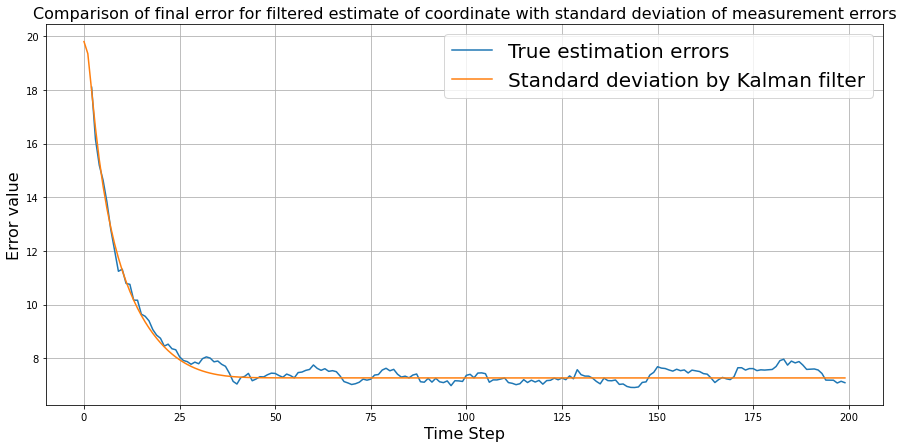

In [21]:
showPlease([e_3,giveElements(kalman_3.givePError(),0)],['True estimation errors', 
            'Standard deviation by Kalman filter'], 
            'Time Step', 'Error value', 
            'Comparison of final error for filtered estimate of coordinate with standard deviation of measurement errors');

**Since this is optimal Kalman filter, calculation errors of estimation provided by the filter correspond to true estimation errors.**

**Now we want to see what happens if $a_i$ is correlated noise on interval over 10 steps. In order to do this, we use $\lambda$ = 0.1 to generate random acceleration $a_i$:**

In [22]:
lambda_4 = 0.1

**initialise new trajectory, measurements and filtered estimates:**

In [23]:
kalman_4 = createProcessGiveKalman(size,initialX_1,initialV_1,T,internalNoiseSigma_1,externalNoiseSigma,
                                   initialKalmanX_3,initialP_3,"usual",[],H,F,G,lambda_4,lambda_1)

In [24]:
#showPlease([kalman_4.trueTrajectory, kalman_4.measTrajectory, kalman_4.kalmanTrajectory],["True trajectory","Measurements", 'Filtered estimates'], 'Time Step', 'Coordinate','Process')

**as well as obtain mean-squared error (true estimation errors):**

In [25]:
e_4,_ = manyKalman(size,500,initialX_1,initialV_1,T,internalNoiseSigma_1,externalNoiseSigma,
               initialKalmanX_3,initialP_3,7,"usual",[],H,F,G,lambda_4,lambda_1)

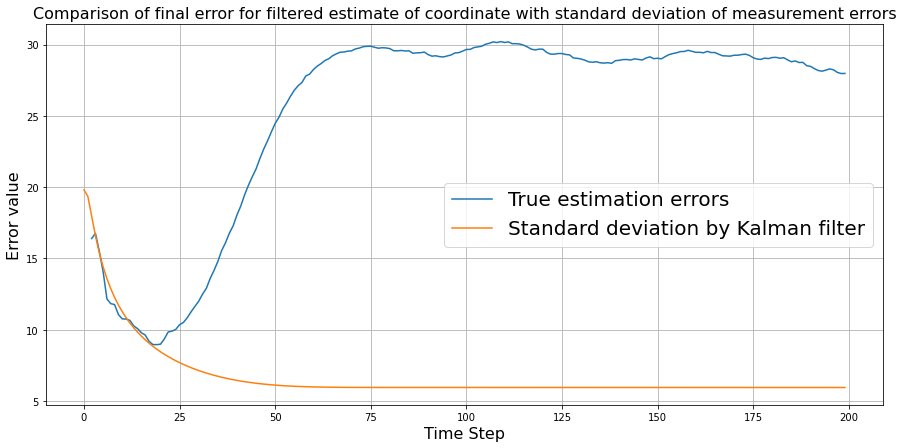

In [26]:
showPlease([e_4,giveElements(kalman_4.givePError(),0)],['True estimation errors', 
            'Standard deviation by Kalman filter'], 
            'Time Step', 'Error value', 
            'Comparison of final error for filtered estimate of coordinate with standard deviation of measurement errors');

**It is a case of non-optimal Kalman filter as assumptions about uncorrelated state noise are not true. Random acceleration is correlated noise. During the first ~20 time steps, true estimation errors show the same trend as standard deviation provided by Kalman filter, but then the former sharpy increase achieving the value of approximately 15 units. Thus, it is essential to consider that Kalman filter provides us filtration with larger errors than the calculated ones due to correlated random acceleration.** 

**This time, let us assume that $a_i$ is uncorrelated noise ($\lambda$ = 1000), but measurement noise $\eta_i$ is correlated on interval over 10 steps ($\lambda$ = 0.1). Firstly, we generate trajectory, measurements and obtain filtered estimates:**

In [27]:
kalman_7 = createProcessGiveKalman(size,initialX_1,initialV_1,T,internalNoiseSigma_1,externalNoiseSigma,
                                   initialKalmanX_3,initialP_3,"usual",[],H,F,G,lambda_1,lambda_4)

**and calculate true estimation errors:**

In [28]:
e_7,_ = manyKalman(size,500,initialX_1,initialV_1,T,internalNoiseSigma_1,externalNoiseSigma,
               initialKalmanX_3,initialP_3,7,"usual",[],H,F,G,lambda_1,lambda_4)

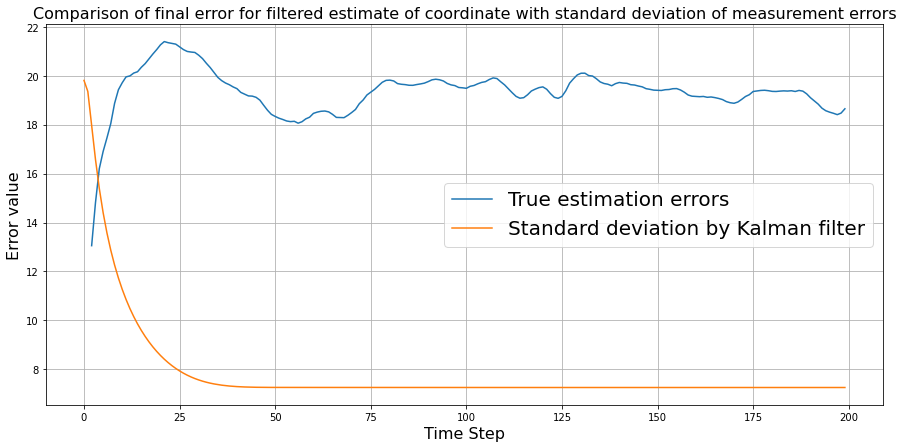

In [29]:
showPlease([e_7,giveElements(kalman_7.givePError(),0)],['True estimation errors', 
            'Standard deviation by Kalman filter'], 
            'Time Step', 'Error value', 
            'Comparison of final error for filtered estimate of coordinate with standard deviation of measurement errors');

**This time, true estimation errors take on larger values compared to the previous case - around 20 units. The accuracy decreased as, in comparison to standard deviation provided by Kalman filter, true errors are now about three times higher.**

**In both cases (with correlated random acceleration and correlated measurement noise) true estimation error turned out to be bigger than the standard deviation values. The former case's values of true estimation errors are app. 2 times higher, while the latter case's values - almost 3 times higher. Thus, correlated measurement noise leads to greater accuracy decrease.**

**Now we want to investigate what happens if both state noise and measurement noise are correlated: $a_i$ and $\eta_i$ are now correlated on interval over 10 steps ($\lambda$ = 0.1), let us generate a trajectory, measurements and than run the filter:**

In [30]:
kalman_11 = createProcessGiveKalman(size,initialX_1,initialV_1,T,internalNoiseSigma_1,externalNoiseSigma,
                                    initialKalmanX_3,initialP_3,"usual",[],H,F,G,lambda_4,lambda_4)

**and one more time compare true estimation errors and standard deviation provided by Kalman filter:**

In [31]:
e_11,_ = manyKalman(size,500,initialX_1,initialV_1,T,internalNoiseSigma_1,externalNoiseSigma,
               initialKalmanX_3,initialP_3,7,"usual",[],H,F,G,lambda_4,lambda_4)

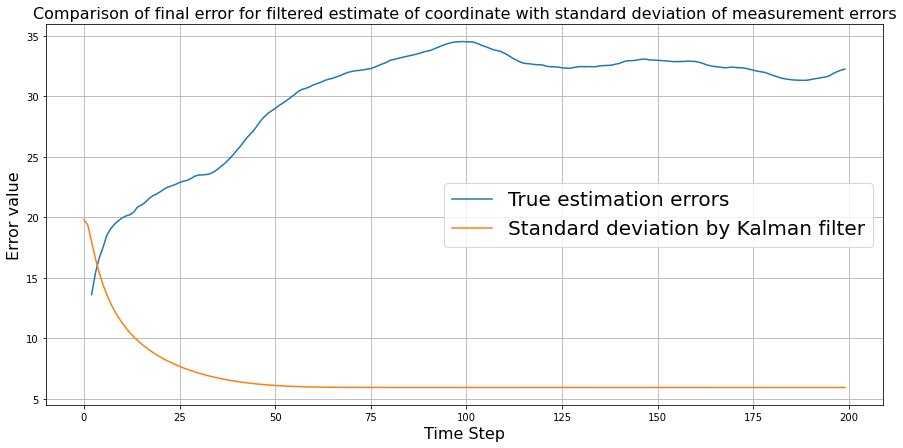

In [32]:
showPlease([e_11,giveElements(kalman_11.givePError(),0)],['True estimation errors', 
            'Standard deviation by Kalman filter'], 
            'Time Step', 'Error value', 
            'Comparison of final error for filtered estimate of coordinate with standard deviation of measurement errors');

**When both state and measurement noise are correlated, the true estimation errors are much higher than those which are calculated by Kalman filter. The accuracy of the obtained figures for true errors differs from the calculated ones by three times. It is essential to optimize Kalman filter algorithm for these cases. In the second part of the assignment, we will optimise Kalman filter algorithm so that it will take into account correlated state noise.**

### Part II. Development of optimal Kalman filter in conditions of correlated state noise

**Firstly, we optimize Kalman filter algorithm so that correlated acceleration is taken into account:**

In [33]:
# Transition matrix F, input matrix G, observation matrix H;
# Initial filtred estimate and initial filtration error covariance matrix

F_2 = np.matrix([[1,T,T**2/2],
                 [0,1,T],
                 [0,0,np.exp(-lambda_4*T)]])
G_2 = np.matrix([[0],
                 [0],
                 [1]])
H_2 = np.matrix([[1,0,0]])

initialKalmanX_2v1 = np.matrix([[2],
                                [0],
                                [0]])
initialP_2v1 = np.matrix([[10000,0,0],
                          [0,10000,0],
                          [0,0,10000]])

In [34]:
class CorrelatedKalmanFilter(KalmanFilter):
    def predict(self,prevX,prevP,F,Q):
        x = F*prevX + self.G * np.random.normal(0,self.noiseSigma**2*(1 - np.exp(-2*self.lambdaProcess)))
        P = F*prevP*F.T + Q
        return x,P

**We need to introduce some changes to our motion function, so that as an output we get an array with acceleration values:**

In [35]:
def motionCorr(initialX,initialV,initialT,lambdaVal,internalNoiseSigma,size):
    vectors = [initialX]
    velocity = [initialV]
    acc = [0]
    acceleration = 0
    v = initialV
    for i in range(1,size):
        acceleration = np.exp(-lambdaVal*initialT)*acceleration + internalNoiseSigma*((1 - np.exp(-2*lambdaVal*initialT))**0.5)*np.random.normal(0, 1)
        vectors.append(vectors[i - 1] + v*initialT + acceleration*initialT**2/2)
        v = v + acceleration * initialT
        velocity.append(v)
        acc.append(acceleration)
    return vectors,velocity,acc

**And now we generate a trajectory, velocity and acceleration arrays:**

In [36]:
x,v,a = motionCorr(initialX_1,initialV_1,T,lambda_4,internalNoiseSigma_1,size)

**and measurements:**

In [37]:
meas = measurements(x,1000,T,20)

**We need some additional functions to calculate the errors:**

In [38]:
def giveAnyVectors(arr):
    X = []
    max_len = len(max(arr,key = lambda x: len(x)))
    for i in range(0,max_len):
        x = [[] for j in range(0,len(arr))]
        for j in range(0,len(arr)):
            if(len(arr[j]) <= i):
                x[j].append(0)
            else:
                x[j].append(arr[j][i])
        X.append(np.matrix((x)))
    return X

In [40]:
def sumLists(arr1,arr2):
    for i in range(len(arr1)):
        arr1[i] = arr1[i] + arr2[i]

def minusAndSqLists(arr1,arr2):
    k = []
    for i in range(len(arr1)):
        k.append((arr1[i] - arr2[i])**2)
    return k

def devideList(arr,val):
    for i in range(0,len(arr)):
        arr[i] = arr[i]/val

def sqRoot(arr):
    for i in range(0,len(arr)):
        arr[i] = arr[i]**0.5

**Here we obtain estimates of state vector by Kalman filter over 500 runs and step-by-step calculate true estimation errors of coordinate, velocity and acceleration:**

In [41]:
errorsX = [0 for i in range(0,200)]
errorsV = [0 for i in range(0,200)]
errorsA = [0 for i in range(0,200)]
step = 7
errExtrX = [0 for i in range(step,200)]
errExtrV = [0 for i in range(step,200)]
errExtrA = [0 for i in range(step,200)]

for i in range(0,500):
    x,v,a = motionCorr(initialX_1,initialV_1,T,lambda_4,internalNoiseSigma_1,size)
    meas = measurements(x,1000,T,20)
    vect = giveAnyVectors([meas,[],[]])
    kalman = CorrelatedKalmanFilter(initialKalmanX_2v1,initialP_2v1,vect,x,"usual",internalNoiseSigma_1,[],H_2,
                F_2,externalNoiseSigma,G_2,0.1)
    kalmanStates = kalman.kalmanStates
    x_k = giveElements(kalmanStates,0)
    v_k = giveElements(kalmanStates,1)
    a_k = giveElements(kalmanStates,2)
    sumLists(errorsX,minusAndSqLists(x,x_k))
    sumLists(errorsV,minusAndSqLists(v,v_k))
    sumLists(errorsA,minusAndSqLists(a,a_k))
    extr = kalman.extrapolate(step)
    extrX = giveElements(extr,0)
    extrV = giveElements(extr,1)
    extrA = giveElements(extr,2)
    sumLists(errExtrX,minusAndSqLists(x[step:],extrX))
    sumLists(errExtrV,minusAndSqLists(v[step:],extrV))
    sumLists(errExtrA,minusAndSqLists(a[step:],extrA))

devideList(errorsX,499)
devideList(errorsV,499)
devideList(errorsA,499)
sqRoot(errorsA)
sqRoot(errorsX)
sqRoot(errorsV)
devideList(errExtrV,499)
devideList(errExtrX,499)
devideList(errExtrA,499)
sqRoot(errExtrA)
sqRoot(errExtrV)
sqRoot(errExtrX)

**We are ready to run Kalman filter again to calculate standard deviation:**

In [42]:
kalman = CorrelatedKalmanFilter(initialKalmanX_2v1,initialP_2v1,vect,x,"usual",0.2,[],H_2,F_2,20,G_2,lambda_4)


**Standard deviation values of coordinate, velocity and acceleration provided by Kalman algorithm:**

In [43]:
pX = giveElements(kalman.givePError(),0)
pV = giveElements(kalman.givePError(),1)
pA = giveElements(kalman.givePError(),2)

**Let us compare true estimation errors (mean-squared) with standard deviation values which were calculated by Kalman filter for coordinate, velocity and acceleration:**

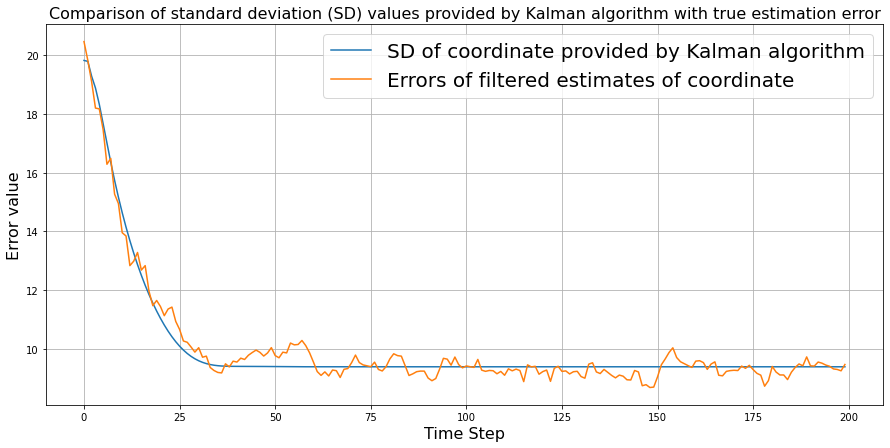

In [56]:
showPlease([pX, errorsX],['SD of coordinate provided by Kalman algorithm', 
          'Errors of filtered estimates of coordinate'],
          'Time Step', 
          'Error value', 
          'Comparison of standard deviation (SD) values provided by Kalman algorithm with true estimation error');

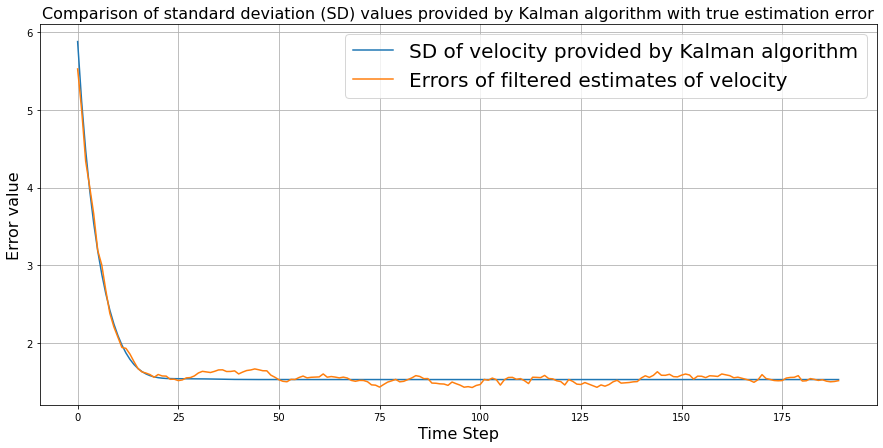

In [57]:
showPlease([pV[10:200], errorsV[10:200]],['SD of velocity provided by Kalman algorithm', 
          'Errors of filtered estimates of velocity'],
          'Time Step', 
          'Error value', 
          'Comparison of standard deviation (SD) values provided by Kalman algorithm with true estimation error');

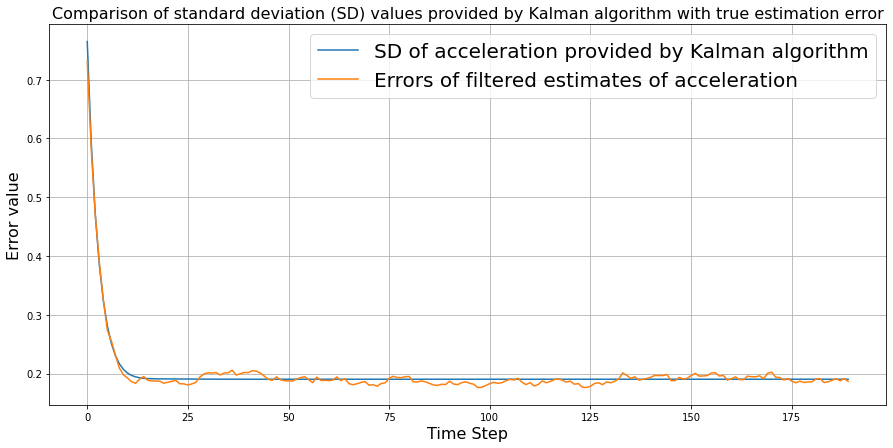

In [59]:
showPlease([pA[10:200],errorsA[10:200]],['SD of acceleration provided by Kalman algorithm', 
          'Errors of filtered estimates of acceleration'],
          'Time Step', 
          'Error value', 
          'Comparison of standard deviation (SD) values provided by Kalman algorithm with true estimation error');

**Three graphs above show that true estimation errors of coordinate, velocity and acceleration correspond respectively to their standard deviations provided by Kalman filter. The algorithm achieved its limit of accuracy due to uncertainty. The error figures for coordinate are less than 10 units, for velocity - less than 2 and for acceleration - less than 0.2. Now let us observe the ability of the filter to forecast 7 steps ahead:**

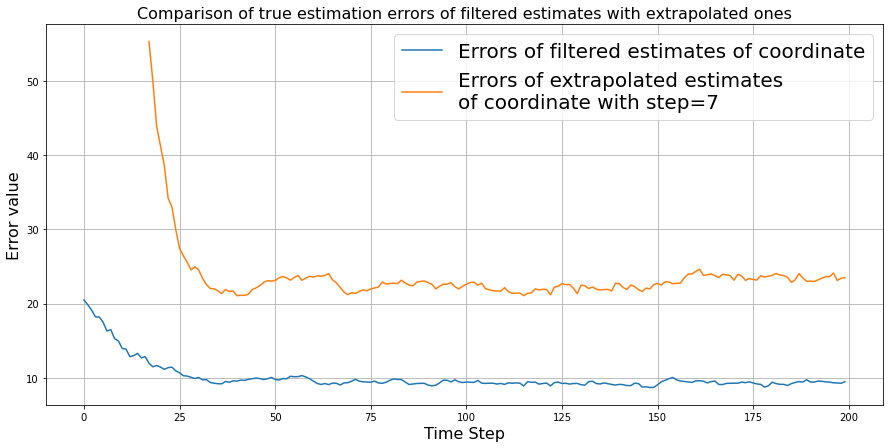

In [60]:
showPlease([errorsX,errExtrX[10:]],
           ['Errors of filtered estimates of coordinate',
            'Errors of extrapolated estimates\nof coordinate with step=7'],
            'Time Step', 
            'Error value', 
            'Comparison of true estimation errors of filtered estimates with extrapolated ones');

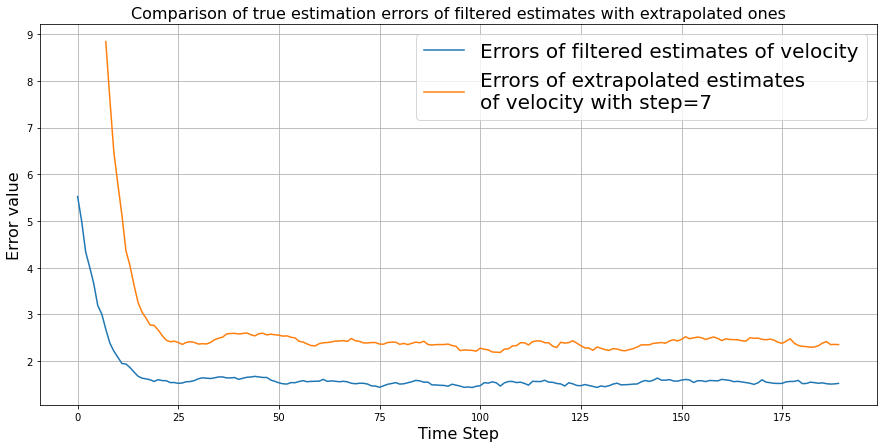

In [61]:
showPlease([errorsV[10:],errExtrV[10:]],
           ['Errors of filtered estimates of velocity',
            'Errors of extrapolated estimates\nof velocity with step=7'],
            'Time Step', 
            'Error value', 
            'Comparison of true estimation errors of filtered estimates with extrapolated ones');

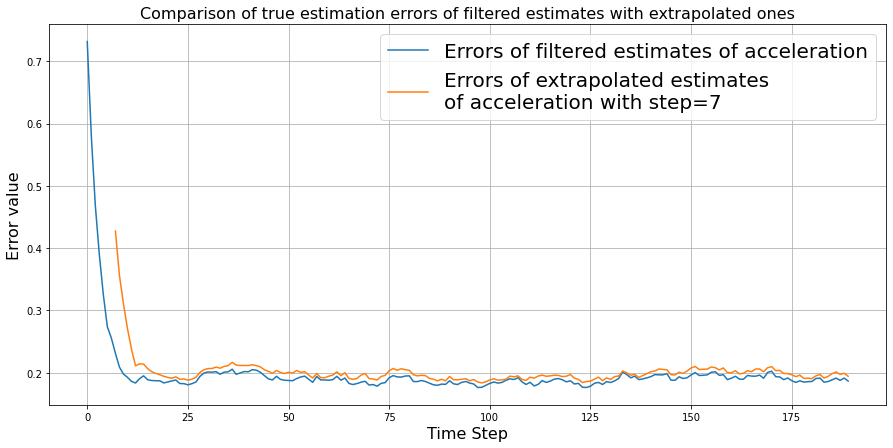

In [64]:
showPlease([errorsA[10:],errExtrA[10:]],
           ['Errors of filtered estimates of acceleration',
            'Errors of extrapolated estimates\nof acceleration with step=7'],
            'Time Step', 
            'Error value', 
            'Comparison of true estimation errors of filtered estimates with extrapolated ones');

**As it is seen from the graphs, errors of extrapolated estimates for coordinate, velocity and acceleration are higher than of just filtered ones - the figures for coordinate and velocity errors are more than doubled, while the values for acceleration (extrapolation case) turn out to be just slightly larger. Thus, the optimized filter's forecasting ability even in case of correlated acceleration shows quite good results.**

**Conclusion: In the first part of the assignment, we found out how non-optimised Kalman filter operates with correlated state and measurement noise. As we expected, the accuracy in both cases dramatically decreased (by ~2 and ~3 times) which was proved by comparison of true estimation errors with standard deviation provided by Kalman filter. Moreover, if we consider the motion where both state and measurement noises are correlated, the drop in the accuracy is even higher (>=3 times). Thus, we realised that Kalman filter is quite sensitive to these kinds of features. As this problem (correlated noise) is typical for many practical control and forecasting problems, we needed to develop an optimised Kalman filter algorithm (as we dealt before with biased state noise case) to take into account at least state noise correlation and eventually see how the error values will behave. We faced many (by many we mean A LOT) issues during the process of optimization but they were basically related to some errors in code (in presentation of the system at state space, for instance). It cost us several days of a nervous search for errors and these were code errors, not the ones we needed. We kept obtaining incorrect results - it was absolutely wrong that we had low true estimation errors and quite large standard deviation values. We tried to rewrite the code three times but nothing worked. Only a fresh look at Kalman filter class revealed the problem we kept ignoring - of course we needed to change matrix Q! After that, everything went smoothly. Once the optimized Kalman filter was ready, we obtained true estimation errors of filtered and extrapolated estimates as well as standard deviation values for coordinate, velocity and acceleration and compared the results. It turned out that true estimation errors corresponded to standard deviation values - the filter was able to take into account correlated state noise so in comparison to results obtained in the first part of the assignment, new Filter truly showed its limit of accuracy. Moreover, extrapolated estimates errors were just slightly higher than the filtered ones showing good forecasting. Thus, improved Kalman algorithm successfully showed its ability to overcome one more widely-spread difficulty - correlated state noise.** 